# 🔧 OCR App: Behind the Scenes

This notebook demonstrates how the OCR application works internally. We'll walk through each component step by step, showing:

1. **Document Classification** - How we identify what type of content is in an image
2. **Text Extraction** - Comparing different OCR engines (Textract, Mistral, OpenAI)
3. **Table Extraction** - Specialized processing for tabular data
4. **Image Extraction** - Detecting and extracting embedded images

Let's dive into the technical details!

## 📦 Setup and Imports

In [ ]:
# Import necessary libraries
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown
import json

# Add the OCR module to path
sys.path.append(os.path.dirname(os.path.abspath('')))

# Import our OCR functions
from functions import (
    classify_image,
    textract_extract_text,
    anthropic_text_ocr,
    anthropic_table_ocr,
    mistral_ocr,
    image_to_bytes,
    format_openai_history,
    base64_to_image,
    Agent,
    Task
)

from prompts import (
    OCR_PROMPT,
)

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

print("✅ Environment loaded successfully!")

✅ Environment loaded successfully!


## 🏷️ Step 1: Document Classification

The first step in our OCR pipeline is to classify the document. This helps us determine which processing methods to apply.

The classification categories are:
- **text**: Plain text document
- **instructions**: Text with formatting markups (strikethrough, underline)
- **table**: Tabular data
- **image**: Contains images, diagrams or maps
- **none**: Empty page or only signatures

In [2]:
IMAGE_PATH = "images/ocr1.png"

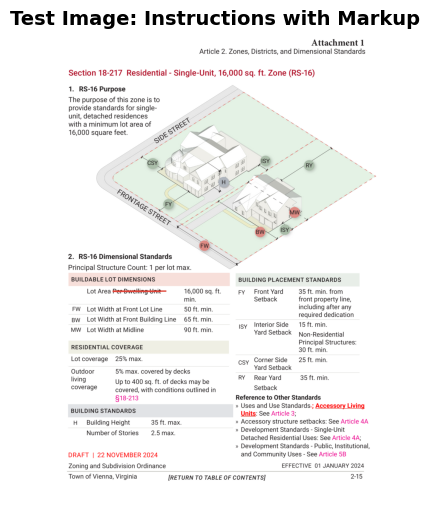

🔍 Classifying 'Instructions with Markup'...


2025-05-31 11:29:59 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


['table', 'image', 'instructions']


In [3]:
# Function to display image and classification
def test_classification(image_path, title):
    image = Image.open(image_path)
    
    # Display image
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image)
    ax.set_title(f"Test Image: {title}", fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.show()
    
    # Classify
    print(f"🔍 Classifying '{title}'...")
    classifications = classify_image(image)
        
    return classifications

# Test on a sample with instructions
classifications = test_classification(IMAGE_PATH, "Instructions with Markup")
print(classifications)

## 📝 Step 2: Text Extraction - Comparing OCR Engines

Once we know what type of document we're dealing with, we can extract text. Let's compare how different OCR engines handle the same image.

### 🏗️ AWS Textract

Textract is Amazon's OCR service. It's fast and reliable for simple text extraction but doesn't understand formatting rules.

In [ ]:
test_image = Image.open(IMAGE_PATH)

In [ ]:
# Extract text using Textract
print("🔄 Running AWS Textract...")
image_bytes = image_to_bytes(test_image)
textract_result = textract_extract_text(image_bytes)

print(textract_result)

🔄 Running AWS Textract...


2025-05-31 11:30:00 - INFO - Found credentials in shared credentials file: ~/.aws/credentials


Attachment 1
Article 2. Zones, Districts, and Dimensional Standards
Section 18-217 Residential - Single-Unit, 16,000 sq. ft. Zone (RS-16)
1. RS-16 Purpose
The purpose of this zone is to
provide standards for single-
unit, detached residences
with a minimum lot area of
16,000 square feet.
SIDE STREET
E
ISY
CSY
E
E
RY
H
H
H
FRONTAGE STREET FY
L
MW
BW
ISY
FW
2. RS-16 Dimensional Standards
Principal Structure Count: 1 per lot max.
BUILDABLE LOT DIMENSIONS
BUILDING PLACEMENT STANDARDS
Lot Area Per Dwelling Unit
16,000 sq. ft.
FY
Front Yard
35 ft. min. from
min.
Setback
front property line,
FW Lot Width at Front Lot Line
50 ft. min.
including after any
required dedication
BW Lot Width at Front Building Line
65 ft. min.
ISY
Interior Side
15 ft. min.
MW Lot Width at Midline
90 ft. min.
Yard Setback
Non-Residential
Principal Structures:
RESIDENTIAL COVERAGE
30 ft. min.
Lot coverage 25% max.
Corner Side
25 ft. min.
CSY
Yard Setback
Outdoor
5% max. covered by decks
RY
Rear Yard
35 ft. min.
living

### 🚀 Mistral OCR

Mistral has a specialized OCR model that can also detect embedded images.

In [13]:
# Extract using Mistral OCR
print("🔄 Running Mistral OCR...")
mistral_result = mistral_ocr(test_image)

display(Markdown(mistral_result.pages[0].markdown))

🔄 Running Mistral OCR...


2025-05-31 11:33:02 - INFO - HTTP Request: POST https://api.mistral.ai/v1/ocr "HTTP/1.1 200 OK"


# Attachment 1 

Article 2. Zones, Districts, and Dimensional Standards

## Section 18-217 Residential - Single-Unit, 16,000 sq. ft. Zone (RS-16)

## 1. RS-16 Purpose

The purpose of this zone is to provide standards for singleunit, detached residences with a minimum lot area of 16,000 square feet.
![img-0.jpeg](img-0.jpeg)

## 2. RS-16 Dimensional Standards

Principal Structure Count: 1 per lot max.

## BUILDABLE LOT DIMENSIONS

| Lot Area Per Bwelling Unit | 16,000 sq. ft. min. |
| :--: | :--: |
| FW Lot Width at Front Lot Line | 50 ft. min. |
| BW Lot Width at Front Building Line | 65 ft. min. |
| MW Lot Width at Midline | 90 ft. min. |

## RESIDENTIAL COVERAGE

Lot coverage $25 \%$ max.
Outdoor 5\% max. covered by decks
living 10 to 400 sq. ft. of decks may be covered, with conditions outlined in §18-213

## BUILDING STANDARDS

| H Building Height | 35 ft. max. |
| :-- | :-- |
| Number of Stories | 2.5 max. |

DRAFT | 22 NOVEMBER 2024
Zoning and Subdivision Ordinance

## BUILDING PLACEMENT STANDARDS

| FY | Front Yard <br> Setback | 35 ft. min. from <br> front property line, <br> including after any <br> required dedication |
| :-- | :-- | :-- |
| ISY | Interior Side <br> Yard Setback | 15 ft. min. <br> Non-Residential <br> Principal Structures: <br> 30 ft. min. |
| CSY | Corner Side <br> Yard Setback | 25 ft. min. |
| RY | Rear Yard <br> Setback | 35 ft. min. |

## Reference to Other Standards

" Uses and Use Standards.; Accessory Living Units: See Article 3;
» Accessory structure setbacks: See Article 4A
» Development Standards - Single-Unit Detached Residential Uses: See Article 4A;
» Development Standards - Public, Institutional, and Community Uses - See Article 5B

### 🧠 OpenAI GPT-4 Vision

OpenAI's GPT-4V can understand complex formatting rules and context.

In [15]:
# Function to use OpenAI for OCR
def openai_ocr(image: Image.Image) -> str:
    """Extract text using OpenAI GPT-4 Vision"""
    try:
        agent = Agent(
            model="gpt-4.1",
            model_type="vision",
            temperature=0.0
        )
        
        
        task = Task(
            user=OCR_PROMPT,
            agent=agent,
            simple_response=True,
        )
        
        response = task.run({"image": image})
        return response
    except Exception as e:
        return f"Error: {str(e)}"

# Extract using OpenAI
print("🔄 Running OpenAI GPT-4 Vision...")
openai_result = openai_ocr(test_image)

print(openai_result)

🔄 Running OpenAI GPT-4 Vision...


2025-05-31 11:34:45 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Section 18-217  Residential - Single-Unit, 16,000 sq. ft. Zone (RS-16)

1. RS-16 Purpose
The purpose of this zone is to provide standards for single-unit, detached residences with a minimum lot area of 16,000 square feet.

<image>

2. RS-16 Dimensional Standards
Principal Structure Count: 1 per lot max.

BUILDABLE LOT DIMENSIONS
Lot Area  16,000 sq. ft. min.
FW  Lot Width at Front Lot Line  50 ft. min.
BW  Lot Width at Front Building Line  65 ft. min.
MW  Lot Width at Midline  90 ft. min.

RESIDENTIAL COVERAGE
Lot coverage  25% max.
Outdoor living coverage  5% max. covered by decks
Up to 400 sq. ft. of decks may be covered, with conditions outlined in §18-213

BUILDING STANDARDS
H  Building Height  35 ft. max.
Number of Stories  2.5 max.

BUILDING PLACEMENT STANDARDS
FY  Front Yard Setback  35 ft. min. from front property line, including after any required dedication
ISY  Interior Side Yard Setback  15 ft. min.
Non-Residential Principal Structures: 30 ft. min.
CSY  Corner Side Yard Set

### 🧠 Anthropic Vision

Claude can understand complex formatting rules and context.

In [8]:
print("🔄 Running Anthropic Vision...")
anthropic_result = anthropic_text_ocr(test_image)

print(anthropic_result)

🔄 Running Anthropic Vision...


2025-05-31 11:30:18 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


Attachment 1
Article 2. Zones, Districts, and Dimensional Standards

Section 18-217 Residential - Single-Unit, 16,000 sq. ft. Zone (RS-16)

1. RS-16 Purpose
The purpose of this zone is to provide standards for single-unit, detached residences with a minimum lot area of 16,000 square feet.

<image>

2. RS-16 Dimensional Standards
Principal Structure Count: 1 per lot max.

<table>

Reference to Other Standards
» Uses and Use Standards; Accessory Living Units: See Article 3;
» Accessory structure setbacks: See Article 4A
» Development Standards - Single-Unit Detached Residential Uses: See Article 4A;
» Development Standards - Public, Institutional, and Community Uses - See Article 5B

DRAFT | 22 NOVEMBER 2024
Zoning and Subdivision Ordinance
Town of Vienna, Virginia                [RETURN TO TABLE OF CONTENTS]                2-15
EFFECTIVE 01 JANUARY 2024


## 📊 Step 3: Table Extraction

For documents containing tables, we use specialized extraction that preserves the table structure.

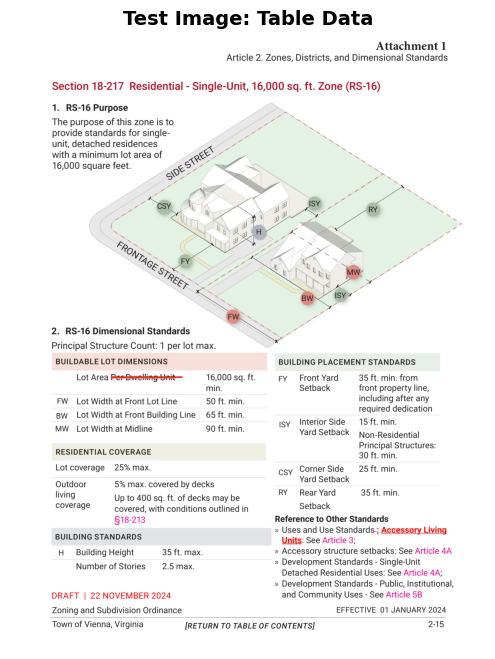

In [9]:
# Load and display a table image
table_image = Image.open(IMAGE_PATH)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(table_image)
ax.set_title("Test Image: Table Data", fontsize=14, fontweight='bold')
ax.axis('off')
plt.show()

In [16]:
# Extract table using specialized table OCR
print("🔄 Running Anthropic Table OCR...")
table_result = anthropic_table_ocr(table_image)

# Display the extracted table
display(HTML("<h4>📊 Extracted Table (HTML format):</h4>"))
if isinstance(table_result, str) and table_result.startswith("<"):
    display(HTML(f"""
    <div style=padding: 20px; border-radius: 5px; margin: 10px 0;'>
        {table_result}
    </div>
    """))
else:
    display(HTML(f"<pre>{table_result}</pre>"))

print("\n💡 The table is extracted as HTML, preserving its structure for easy display and processing.")

🔄 Running Anthropic Table OCR...


2025-05-31 11:35:59 - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"



💡 The table is extracted as HTML, preserving its structure for easy display and processing.


## 🖼️ Step 4: Image Extraction

Mistral OCR has special capabilities to detect and extract embedded images from documents.

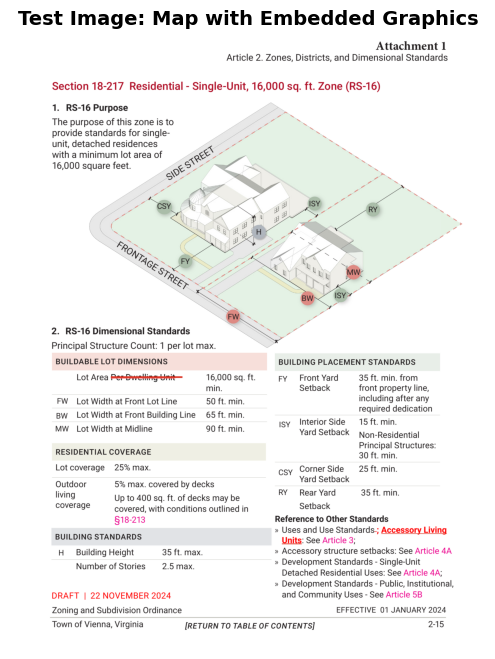

In [11]:
# Load an image with embedded graphics (map)
map_image = Image.open(IMAGE_PATH)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(map_image)
ax.set_title("Test Image: Map with Embedded Graphics", fontsize=14, fontweight='bold')
ax.axis('off')
plt.show()

🔄 Running Mistral OCR for image detection...


2025-05-31 11:30:43 - INFO - HTTP Request: POST https://api.mistral.ai/v1/ocr "HTTP/1.1 200 OK"



✨ Detected 1 embedded images!


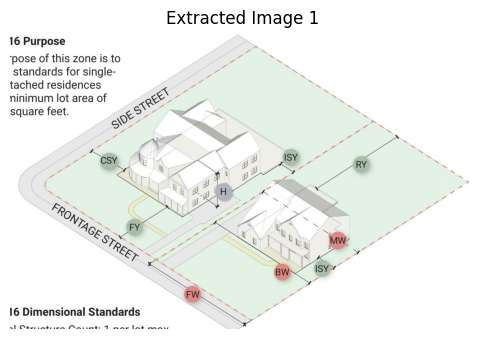

In [12]:
# Extract using Mistral to detect images
print("🔄 Running Mistral OCR for image detection...")
mistral_map_result = mistral_ocr(map_image)

# Check for detected images
if mistral_map_result and mistral_map_result.pages and mistral_map_result.pages[0].images:
    images = mistral_map_result.pages[0].images
    print(f"\n✨ Detected {len(images)} embedded images!")
    
    # Display first few detected images
    for idx, img_data in enumerate(images[:3]):
        display(HTML(f"<h4>🖼️ Detected Image {idx + 1}:</h4>"))
        
        # Convert and display the image
        if hasattr(img_data, 'image_base64'):
            try:
                detected_img = base64_to_image(img_data.image_base64)
                
                fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                ax.imshow(detected_img)
                ax.set_title(f"Extracted Image {idx + 1}", fontsize=12)
                ax.axis('off')
                plt.show()
            except:
                print(f"Could not display image {idx + 1}")
        
        if hasattr(img_data, 'description'):
            print(f"Description: {img_data.description}")
else:
    print("No images detected in this document.")

## 🎯 Summary

This notebook showed the complete OCR pipeline:

1. **Classification** determines what type of content we're dealing with
2. **Text extraction** uses different engines based on requirements
3. **Table extraction** preserves structure in HTML format
4. **Image extraction** detects and extracts embedded graphics

The modular design allows you to:
- Swap OCR engines based on your needs
- Customize prompts for specific use cases
- Add new processing steps
- Optimize for speed or accuracy

Feel free to modify any component to fit your specific requirements!